# NBA Player Points

### Group Members:
Matthew Gillies - 59188508 (Group Leader),
Hans Lam - 80010721,
Kyle Sava - 40429243



### Group Contributions:
Matthew: R code appendix, 
...



## Objective: 
We are looking to analyze NBA points data for players who have both played in the regular season and playoffs in order to determine the average points per game for the regular season and playoffs along with whether the average player performs better in the playoffs. 

## Background: 
In the NBA the regular season and playoffs are very different in terms of player usage and rotations. We often see star players "coast" through the regular season in order to save energy and maintain health for the playoffs. Some players raise their level of play during the playoffs, while others become overwhelmed with pressure and fail to produce to their usual standards. Our goal is to determine whether the average NBA player performs better in the playoffs than the regular season, along with standalone estimates for both the regular season and playoffs. There are many underlying factors to this analysis, including rotations becoming shorter in the playoffs, allowing star players more opportunities to score and average role players less. The playoffs are also an overall higher level of competition, as only teams who were successful enough in the regular season compete. Through this analysis we hope to further understand the relationship and nuances between regular season and playoff scoring. 

## Importance: 
During the last NBA season, the 8-th seeded Miami Heat made the NBA finals. This is only the second time that an 8-th seeded team has made it all the way to the NBA finals, with the first time being all the way back in 1999. Naturally, this created a strong underdog narrative for the Miami Heat during last season's playoffs where many sports commentators were pointing out how much better the Miami Heat players were playing during the playoffs compared to the regular season. In particular, the Miami Heat's star player Jimmy Butler received the moniker of "Playoff Jimmy" due to the perceived difference in his level of play in the playoffs when compared to the regular season. This narrative of the Miami Heat players suddenly becoming better during the playoffs made our group wonder if this increase in level of play between the regular season and the playoffs applied to all NBA players in general, leading to the aforementioned objective of this project.



## Sampling: 
The target population we chose to sample from is the NBA players who played during both the 2022/2023 NBA regular season and the 2022/2023 NBA playoffs. We chose this population due to the following reasons:
1. Due to this being the most recent completed NBA season, the data was easily accessible.
2. During the last NBA season, the 8-th seeded Miami Heat made it to the NBA finals. As stated previously, the narrative presented by sports media was that everyone on that team was playing better in the playoffs. By including those Miami Heat players in our population, we can see if the data supports that narrative, and if that idea can be generalized to all players as a whole.

Our parameters of interest for measuring the difference in performance for NBA players between the regular season and the playoffs are:
1. PPG (points per game) per player during the 2022/2023 NBA regular season
2. PPG per player during the 2022/2023 NBA playoffs
3. Proportion of players who had a higher PPG during the playoffs compared to their PPG during the regular season

The two sampling methods we chose to use are simple random sampling and stratified sampling. 
For our simple random sample, we chose $n = 50$ players at random and recorded their PPG for both the regular season and the playoffs. 

For our stratified sample, since the cost of sampling is 0 for all players, we decided to set an arbitrary sample size of $n = 50$ (matching the sample size for the SRS). We decided to choose our stratas based on player positions, giving us the $h = 5$ stratas of "C" (center), "PF" (power forward), "PG" (point guard), "SF" (small forward), and "SG" (shooting guard). The reasons for choosing player position to define our stratas are: 
1. The between-strata variation for player position should be relatively large. Again harking back to the defined roles for each position, these roles also make the average in points scored between positions fairly different. For example, centers are mainly responsible for rebounds and scoring closer to the basket. Shooting guards on the other hand are mainly responsible for taking many long-range 3-pointer shots. Thus, the average of points scored should be lower for centers when compared to the position of shooting guard, since shooting guards have opportunities to score more when compared to centers. 
2. The within-strata variation for player position should be relatively minimial. Since each position has defined roles for players, the players of each position should be scoring in similar ways with one another by fulfilling those defined roles. For example, though the quality of center players may vary within the NBA, the way that centers score should remain about the same between centers. This in turn should minimize the difference in points scored within positions since the players of each position should score (and fulfill their roles) in about the same way.
To choose the sample sizes for each strata, we took a look at the overall sizes ($N_h$) of each position in our dataset as well as the sample standard deviation for PPG within each position. Using the proportionality of $n_h \propto N_h * s_{h, guess}$, we determined each strata's sample size by divying up the $n = 50$ proportionally based on each strata's $N_h * s_{h, guess}$, resulting in:
1. $n_c = 10$ for the center position "C"
2. $n_pf = 10$ for the power forward position "PF"
3. $n_pg = 9$ for the point guard position "PG"
4. $n_sf = 10$ for the small forward position "SF"
5. $n_sg = 11$ for the shooting guard position "SG" 

## Data Analysis:
Our population consists of all NBA players who played at least one minute in both a regular season and playoff game, which came out to be $N = 200$ total players. From this population we will sample $n = 50$ players using both SRS and stratified methods, utilizing the same players in our regular season and playoff samples (ie. The same players will be present in both the playoff and regular season SRS samples). After obtaining these samples we will obtain three different estimates: the average points per game in the regular season, the average points per game in the playoffs, and the proportion of players who score more in the playoffs than the regular season. From these estimates we will obtain the respective standard errors, and the calculate 95% confidence intervals. For the following estimates we utilize the FPC of $\sqrt{1-n/N}$ for SRS or $\sqrt{1-n_h/N}$ for stratified sampling where relevant within our standard error estimates, as $n/N  = 50/200 = 0.25 > 0.05$. We also operate under the assumption that the data is distributed approximately normally through the CLT, which is applied through the use of the Normal 0.95 quantile for our confidence intervals.  

#### Formulas:

##### SRS for continuous estimates:
$\bar{y} = (1/N)\sum(y_i)$ 

$SE(\bar{y}) = \sqrt{(s^2/n) * 1-n/N} $

95% CI = $\bar{y} +- 1.96*SE(\bar{y}) $

##### Stratified for continuous estimates:
$\bar{y_h} = \sum_{i = 1}^{n_h} y_i$

$\bar{y} = \sum(N_h/N * \bar{y_h})$

$SE(\bar{y}) = \sqrt{\sum((N_h/N)^2 * (1-n_h/N_h) * s^2_h/n_h)} $

95% CI = $\bar{y} +- 1.96*SE(\bar{y}) $

##### SRS for proportion estimate:
$\hat{p} = \sum(Ptsplayoff > Ptsreg)$ where Ptsplayoff is points per game in the playoffs for a single player, and Ptsreg is points per game in the regular season. 

$SE(\hat{p}) = \sqrt{(p*(1-p)/n) * (1-n/N)}$

95% CI = $\hat{p} +- 1.96*SE(\hat{p}) $

##### Stratified for proportion estimate: 
$\hat{p_h} = \sum_{i=1}^{n_h} Ptsplayoff_i > Ptsreg_i$ Using same definitions as above

$\hat{p} = 1/h * \sum \hat{p_h}$

$SE(\hat{p}) = \sqrt{\sum((N_h/N)^2 * (1-n_h/N_h) * s^2_h/n_h)} $

95% CI = $\hat{p} +- 1.96*SE(\hat{p}) $


For regular season SRS we obtained an estimate of 9.562 points per game, with a standard error of 0.785. This produced a 95% confidence interval of [8.31, 10.81]. From this we can conclude that for 95% of repeated samples of NBA players, the average points per game will fall within [8.31, 10.81] using simple random sampling. For the stratified approach to the regular season we obtained an estimate of 10.171 points per game with a standard error of 0.766, which produces a 95% confidence interval of [8.91, 11.43]. Once again we interpret this as for 95% of repeated stratified samples for the regular season, the estimate for points per game will fall within the range of [8.91, 11.43]. For the simple random sample utilizing the playoff data, we obtain an estimate of 7.182 points per game with a standard error of 0.83, which produces a 95% confidence interval of [5.82, 8.55]. Similarily, for 95% of repeated simple random samples for the playoff data, the estimate for points per game will fall within the range of [5.82, 8.55]. Utilizing the stratified sampling on the playoff data, we achieve an estimate of 8.428, with a standard error of 0.943, which produces a 95% confidence interval of [6.88, 9.98]. Therefore for 95% of repeated stratified samples of the playoff data, the estimate will fall within the range [6.88, 9.98]. Utilizing an SRS we achieved an estimate of 0.14 for the proportion of players who increased their point production in the playoffs, with a standard error of 0.042. This produced a 95% confidence interval of [0.0701, 0.2099], and therefore for 95% of repeated SRS samples the proportion will fall within this range. Utilizing our stratified sampling method, we achieved a point estimate of 0.286 for the proportion of player improving their scoring output in the playoffs, with a standard error of 0.055. From these values we obtain a 95% confidence interval of [0.195, 0.377], and therefore for 95% of repeated stratified samples the estimate for the proportion of players scoring more in the playoffs will fall within the range of [0.195, 0.377]. 



## Conclusion: 

During the 2022/2023 NBA season playoffs, the Miami Heat had a historic performace coming in as an 8 seed. This prompted us to question if there is any evidence of a universal trend of heightened player performance during the playoffs, both regular and post-season games, and ascertain their scoring abilities. Our assessment has this as its principal aim. In our analysis, we looked into the points per game (PPG) data of players who took part in both regular season and playoff matches. This data was obtained by meticulously parsing the player dataset, filtering for onlt players that had not been traded, and played for one team in both playoffs and the regular season. To do this analysis, we used a combination of simple random sampling (SRS) and stratified sampling techniques. The results we obtained offer a nuanced perspective on how players perform during these distinct competitive stages.

From our SRS, the PPG for the regular season had an average of 9.562, with a 95% confidence interval of [8.31, 10.81]. Our playoff sample had a notyably lower PPG estimate, with an average of 7.182, and a confidence interval of [5.82, 8.55]. The stratified samples yielded similar trends, having a higher regular season average PPG of 10.171 (95% CI: [8.91, 11.43]) and a lower average playoff PPG of 8.428 (95% CI: [6.88, 9.98]). Interestingly, our analysis on the proportion of players who improved their scoring in the playoffs compared to the regular season revealed contrasting results between the two sampling methods. The SRS estimated that only 14% of players increased their scoring in the playoffs (95% CI: [0.0701, 0.2099]), whereas the stratified sample suggested a higher proportion of 28.6% (95% CI: [0.195, 0.377]). This inter-sample variance highlights the importance of choice of sampling methods in statistical analysis and interpretation. Our research findings indicate that although there are certain individuals who excel during playoff games, the overall trend in the league does not seem to support this notion; on the contrary, it suggests quite the opposite. Several factors come into play here, including intensified competition among teams, enhanced defensive strategies employed by opponents, and the physical toll endured throughout a demanding regular season. These elements collectively contribute to a noticeable decline in average points per game (PPG) during playoff matches. This study significantly adds to ongoing discussions surrounding player performance at different stages of an NBA season. By providing empirical evidence to the sports community, it aids in comprehending how player dynamics unfold within this context. Moreover, our investigation sheds light on statistical methodologies as indispensable tools for analyzing sports-related data—indeed any form of data—and extracting insights that surpass mere speculation. Consequently, we emphasize both their relevance and applicability beyond sport-specific inquiries.

It is important to acknowledge the limitations of our study. The main constraint lies in the narrow focus on points per game (PPG) as the sole measure of performance, disregarding other crucial aspects such as assists, rebounds, defensive plays, and player efficiency. By doing so, we have inadvertently neglected a significant portion of a player's overall contribution to basketball. Furthermore, we failed to account for the dynamic nature of playoff games where higher stakes and intensified competition often lead to changes in team strategies and individual roles. These strategic shifts can greatly influence individual performances during playoffs which were not adequately considered in our analysis. Consequently, relying solely on PPG may oversimplify the complexity inherent in playoff basketball. Another limitation stems from our sampling approach despite its robustness. Although simple random sampling (SRS) and stratified sampling are effective methods for obtaining representative samples; they might not fully capture population variability within each category or position due to diverse playing styles and roles among players sharing similar positions. Moreover, setting an arbitrary sample size of $n=50$ for both SRS and stratified sampling could potentially restrict us from gaining a comprehensive understanding of player performances. A larger sample size would have allowed us greater insights into this area specifically when estimating proportions concerning scoring increases during playoffs—where notable differences emerged between SRS and stratified samples. Considering these methodological constraints alongside data scope limitations necessitates caution when interpreting conclusions drawn from our study. While we offer valuable insights into NBA players' scoring performances across regular seasons versus playoffs; it is imperative not to generalize these findings as definitive statements about overall player performance since there are additional factors at play that demand further investigation.
The discrepancies observed between results obtained through SRS versus stratified sampling methodologies also emphasize that different analytical frameworks may yield divergent conclusions altogether.

To summarize our findings: while narratives such as "Playoff Jimmy" may capture public imagination due to exceptional performances from specific players during postseason encounters; these stories do not universally apply across all athletes participating in professional basketball leagues like NBA. The typical NBA player does not necessarily exhibit improved scoring abilities when competing in playoffs—a fact that underscores just how intricate and unique individual performances can be under high-pressure circumstances. Our analysis thus presents exciting opportunities for future investigations aimed at exploring alternative performance metrics and their variations throughout an entire NBA season


## Appendix

#### R code:

In [6]:
library(tidyverse)
set.seed(123)
playoff_data <- read.csv("202223nbaplayoffs.csv", header = T)
reg_data <- read.csv("202223regseasonnodupes.csv", header = T)

## SRS sampling
common_sample_indices <- sample(1:nrow(reg_data), 50)

sample_size <- 50
population_size <- 200

# SRS for Regular season
srs_sample_reg <- reg_data[common_sample_indices, ]
srs_est_reg <- mean(srs_sample_reg$PTS)
fpc <- 1 - sample_size / population_size
se_reg <- sqrt(var(srs_sample_reg$PTS)/sample_size * fpc)
quantile <- qnorm(0.95)
CI_reg <- c(srs_est_reg - quantile*se_reg, srs_est_reg + quantile*se_reg)


# SRS for Playoffs
srs_sample_playoffs <- playoff_data[common_sample_indices, ]
srs_est_playoffs <- mean(srs_sample_playoffs$PTS)
se_playoffs <- sqrt(var(srs_sample_playoffs$PTS)/sample_size * fpc)
CI_playoffs <- c(srs_est_playoffs - quantile*se_playoffs, srs_est_playoffs +
                   quantile*se_playoffs)

## Stratified Sampling for regular season:
stratum_sizes <- reg_data %>%
  group_by(Pos) %>%
  summarize(StratumSize = n())

within_strata_vars <- reg_data %>%
  group_by(Pos) %>%
  summarize(SD = sd(PTS))

## We see that Within-Strata Variance are varying so we use optimal allocation
## Here we assume the cost of sampling from each strata is the same

se_strata <- stratum_sizes$StratumSize * within_strata_vars$SD
samp_sizes_strat <- round(se_strata/sum(se_strata) * sample_size)

samp_sizes_strat[3] = 9

## We round the point guard strata size down to ensure the total sample size 
## is 50, although it should technically round up. 


final_samples <- data.frame()  # Initialize an empty dataframe to store the final samples

for (i in 1:5) {
  samp_size <- samp_sizes_strat[i]
  current_stratum <- unique(reg_data$Pos)[i]
  
  stratum_samples <- reg_data %>%
    group_by(Pos) %>%
    filter(Pos == current_stratum) %>%
    sample_n(samp_size)
  
  final_samples <- rbind(final_samples, stratum_samples)
}

## Check to make sure sampling is done correctly: 
check_stratsize <- final_samples %>%
  group_by(Pos) %>%
  summarize(Size = n())


## Estimating Stratified for Regular Season: 
N <- nrow(reg_data)
Nh_data <- reg_data %>% group_by(Pos) %>% summarize(n = n())
Nh <- Nh_data$n
pos_avg <- final_samples %>% group_by(Pos) %>% summarize(mean = mean(PTS))
pos_means <- pos_avg$mean

strat_est_reg <- sum((Nh/N)*pos_means)

pos_vars_dat <- final_samples %>% group_by(Pos) %>% summarize(Var = var(PTS))
pos_vars <- pos_vars_dat$Var

se_strat_reg <- sqrt(sum((Nh/N)^2 * (1-(samp_sizes_strat/Nh)) * 
                           (pos_vars/samp_sizes_strat)))
CI_strat_reg <- c(strat_est_reg - quantile*se_strat_reg, 
                  strat_est_reg + quantile*se_strat_reg)

## Getting stratified sample for Playoffs: 
strat_players <- final_samples$Player
playoffs_strat <- playoff_data %>% filter(Player %in% strat_players)

## Estimating stratified for playoffs: 
N <- nrow(playoff_data)
pos_avg_p <- playoffs_strat %>% group_by(Pos) %>% summarize(mean = mean(PTS))
pos_means_p <- pos_avg_p$mean

strat_est_playoff <- sum((Nh/N)*pos_means_p)

pos_vars_dat_p <- playoffs_strat %>% group_by(Pos) %>% summarize(Var = var(PTS))
pos_vars_p <- pos_vars_dat_p$Var

se_strat_p <- sqrt(sum((Nh/N)^2 * (1-(samp_sizes_strat/Nh)) * 
                           (pos_vars_p/samp_sizes_strat)))
CI_strat_reg <- c(strat_est_playoff - quantile*se_strat_p, 
                  strat_est_playoff + quantile*se_strat_p)

## Proportion Estimate for players who score more in playoffs than regular 
## season:

## SRS
merged_data <- merge(srs_sample_reg, srs_sample_playoffs, by = "Player", 
                     suffixes = c("_reg", "_playoff"))
prop_playoff_srs <- mean(merged_data$PTS_playoff > merged_data$PTS_reg)
se_prop_srs <- sqrt(fpc*((prop_playoff_srs* (1-prop_playoff_srs))/sample_size))
CI_prop_srs <- c(prop_playoff_srs - quantile*se_prop_srs, 
                 prop_playoff_srs + quantile*se_prop_srs)

## Stratified: 
merged_strat <- merge(final_samples, playoffs_strat, by = "Player", 
                      suffixes = c("_reg", "_playoff"))
merged_strat$Playoff_Higher <- ifelse(merged_strat$PTS_playoff > 
                                        merged_strat$PTS_reg, 1, 0)

props <- merged_strat %>% group_by(Pos_reg) %>%
  summarize(Prop = mean(Playoff_Higher))
strat_props <- props$Prop
strat_est_prop <- sum((Nh/N)*strat_props)

vars_prop_dat <- merged_strat %>% group_by(Pos_reg) %>%
  summarize(Var = var(Playoff_Higher))
vars_prop <- vars_prop_dat$Var

se_prop_strat <- sqrt(sum((Nh/N)^2 * (1-(samp_sizes_strat/Nh)) * 
                            (vars_prop/samp_sizes_strat)))
CI_prop_strat <- c(strat_est_prop - quantile*se_prop_strat, 
                   strat_est_prop + quantile*se_prop_strat)


cont_estimates_df <- data.frame(
  Season = c("Regular SRS", "Playoff SRS", 'Regular Stratified', 'Playoff Stratified'),
  Mean_PTS = c(srs_est_reg, srs_est_playoffs, strat_est_reg, strat_est_playoff),  
  Lower_CI = c(CI_reg[1], CI_playoffs[1], CI_strat_reg[1], CI_strat_play[1]),      
  Upper_CI = c(CI_reg[2], CI_playoffs[2],CI_strat_reg[2], CI_strat_play[2])      
)

prop_est_df <- data.frame(
  Season = c("SRS", "Stratified"),
  Prop = c(prop_playoff_srs, strat_est_prop),
  Lower_CI = c(CI_prop_srs[1], CI_prop_strat[1]),
  Upper_CI = c(CI_prop_srs[2], CI_prop_strat[2])
)

ERROR: Error in eval(expr, envir, enclos): object 'CI_strat_play' not found


### Plots

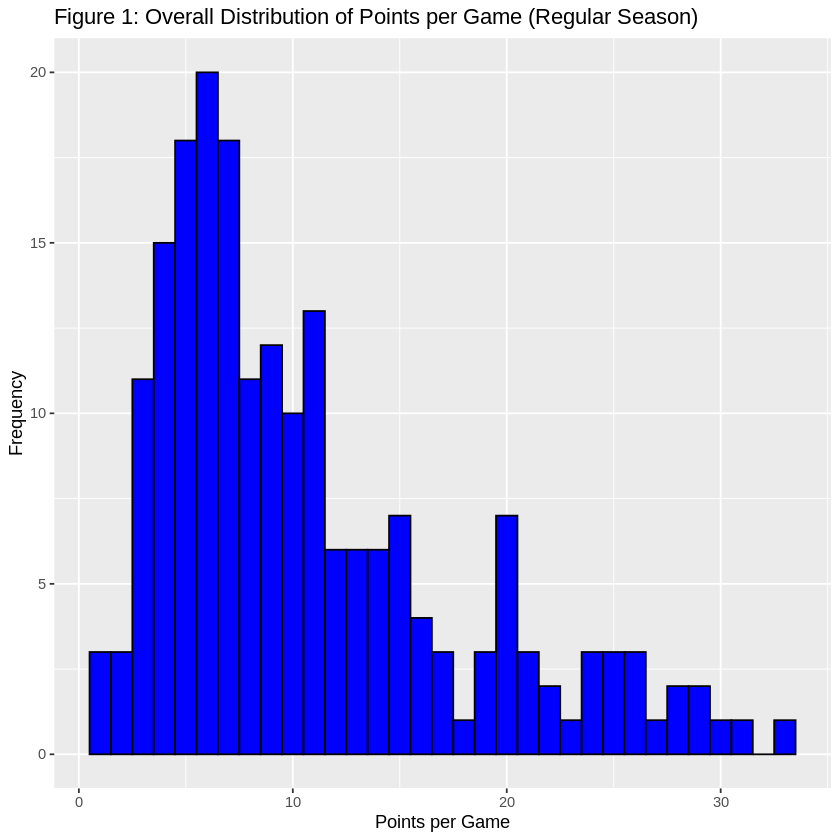

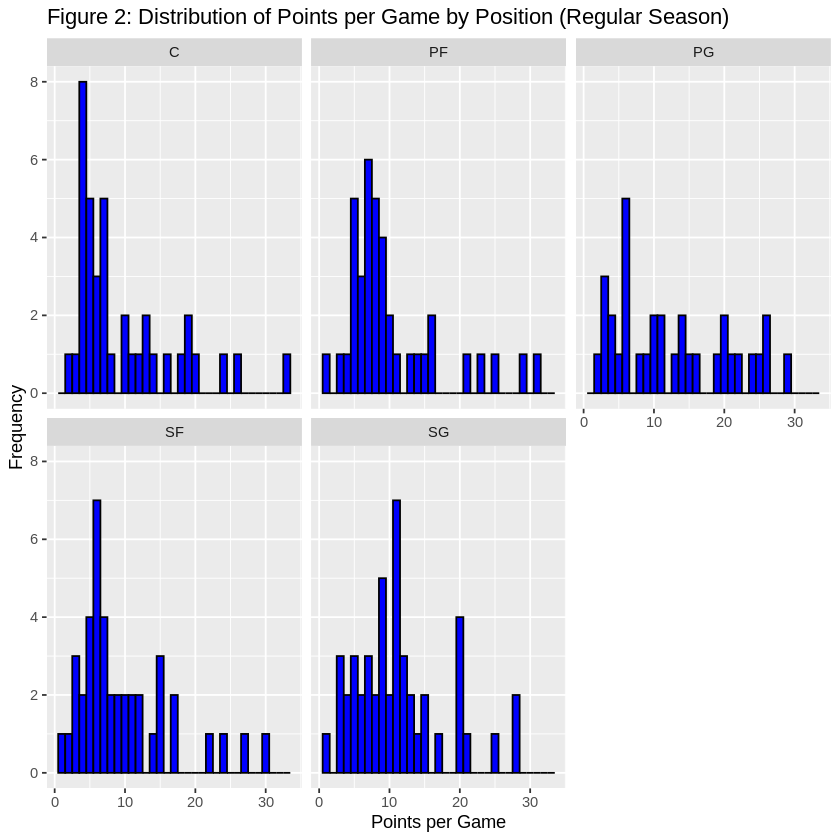

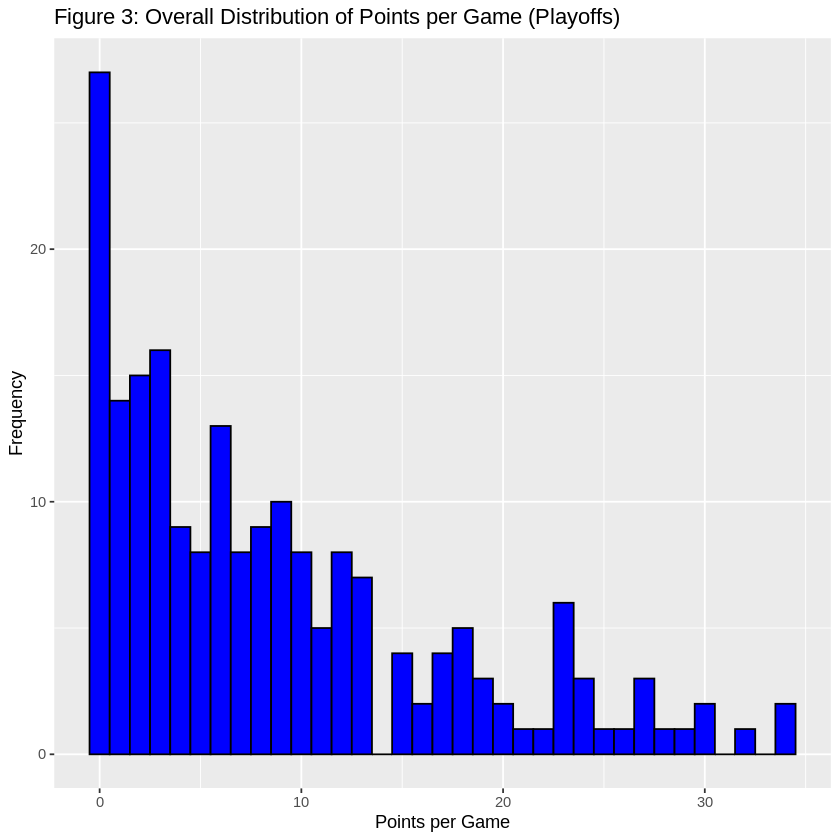

ERROR: Error in eval(expr, envir, enclos): object 'cont_estimates_df' not found


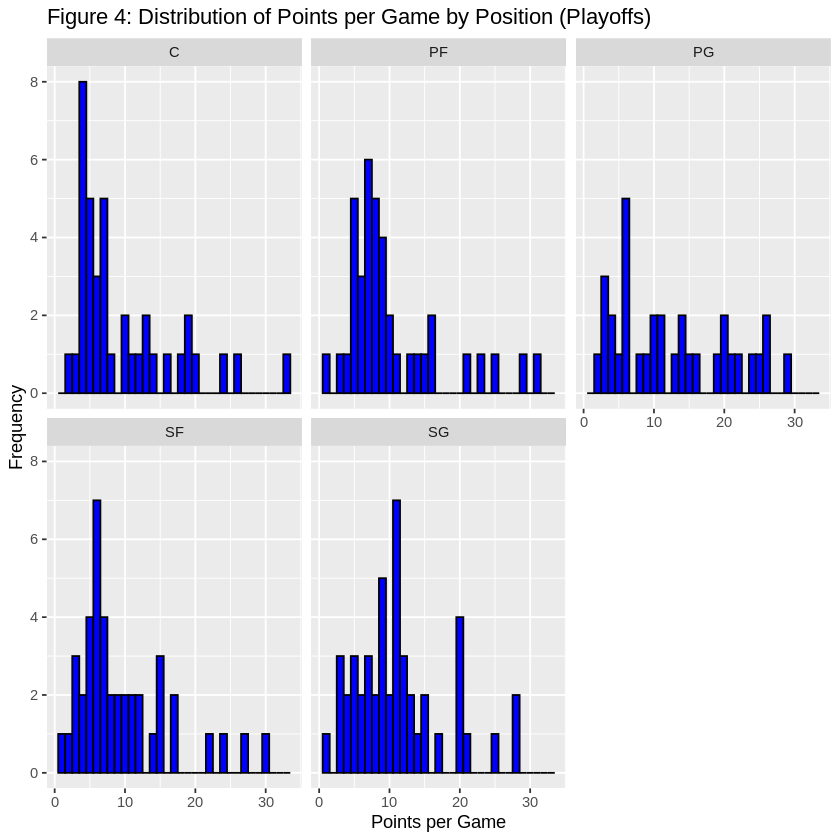

In [7]:
ggplot(reg_data, aes(x = PTS)) +
  geom_histogram(binwidth = 1, fill = "blue", color = "black") +
  labs(title = "Figure 1: Overall Distribution of Points per Game (Regular Season)",
       x = "Points per Game",
       y = "Frequency")


ggplot(reg_data, aes(x = PTS)) +
  geom_histogram(binwidth = 1, fill = "blue", color = "black") +
  facet_wrap(~ Pos) +
  labs(title = "Figure 2: Distribution of Points per Game by Position (Regular Season)",
       x = "Points per Game",
       y = "Frequency")

ggplot(playoff_data, aes(x = PTS)) +
  geom_histogram(binwidth = 1, fill = "blue", color = "black") +
  labs(title = "Figure 3: Overall Distribution of Points per Game (Playoffs)",
       x = "Points per Game",
       y = "Frequency")


ggplot(reg_data, aes(x = PTS)) +
  geom_histogram(binwidth = 1, fill = "blue", color = "black") +
  facet_wrap(~ Pos) +
  labs(title = "Figure 4: Distribution of Points per Game by Position (Playoffs)",
       x = "Points per Game",
       y = "Frequency")
    
ggplot(cont_estimates_df, aes(x = Season, y = Mean_PTS)) +
  geom_point(color = 'red') +
  geom_errorbar(aes(ymin = Lower_CI, ymax = Upper_CI), width = 0.2) +
  labs(title = "Figure 5: Continuous Estimates with Confidence Intervals",
       x = "Method",
       y = "Mean Points per Game")
    
ggplot(prop_est_df, aes(x = Season, y = Prop)) +
  geom_point(color = 'red') +
  geom_errorbar(aes(ymin = Lower_CI, ymax = Upper_CI), width = 0.2) +
  labs(title = "Figure 6: Proportion Estimates with Confidence Intervals",
       x = "Method",
       y = "Proportion Estimate")

#### Regular Season Data

In [8]:
reg_data <- read.csv("202223regseasonnodupes.csv", header = T)
reg_data

X,Unnamed..0,Rk,Player,Pos,Age,Tm,G,GS,MP,⋯,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Player.additional
<int>,<int>,<int>,<chr>,<chr>,<int>,<chr>,<int>,<int>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,2,3,Bam Adebayo,C,25,MIA,75,75,34.6,⋯,2.5,6.7,9.2,3.2,1.2,0.8,2.5,2.8,20.4,adebaba01
2,4,5,Santi Aldama,PF,22,MEM,77,20,21.8,⋯,1.1,3.7,4.8,1.3,0.6,0.6,0.8,1.9,9.0,aldamsa01
3,7,6,Nickeil Alexander-Walker,SG,24,MIN,23,0,15.5,⋯,0.3,1.5,1.8,1.4,0.3,0.3,0.4,1.3,5.9,alexani01
4,8,7,Grayson Allen,SG,27,MIL,72,70,27.4,⋯,0.8,2.4,3.3,2.3,0.9,0.2,1.0,1.6,10.4,allengr01
5,9,8,Jarrett Allen,C,24,CLE,68,68,32.6,⋯,3.3,6.5,9.8,1.7,0.8,1.2,1.4,2.3,14.3,allenja01
6,11,10,Kyle Anderson,PF,29,MIN,69,46,28.4,⋯,1.0,4.4,5.3,4.9,1.1,0.9,1.5,2.1,9.4,anderky01
7,12,11,Giannis Antetokounmpo,PF,28,MIL,63,63,32.1,⋯,2.2,9.6,11.8,5.7,0.8,0.8,3.9,3.1,31.1,antetgi01
8,13,12,Thanasis Antetokounmpo,PF,30,MIL,37,0,5.6,⋯,0.4,0.8,1.2,0.4,0.1,0.1,0.3,0.6,1.4,antetth01
10,20,17,Deandre Ayton,C,24,PHO,67,67,30.4,⋯,2.6,7.4,10.0,1.7,0.6,0.8,1.8,2.8,18.0,aytonde01


#### Playoff Data

In [9]:
playoff_data <- read.csv("202223nbaplayoffs.csv", header = T)
playoff_data

X,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,⋯,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Player.additional
<int>,<int>,<chr>,<chr>,<int>,<chr>,<int>,<int>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0,1,Bam Adebayo,C,25,MIA,23,23,37.0,7.3,⋯,2.7,7.1,9.9,3.7,0.9,0.7,2.7,3.1,17.9,adebaba01
1,2,Santi Aldama,PF,22,MEM,6,0,16.8,2.5,⋯,1.2,3.2,4.3,1.2,0.5,0.0,0.3,0.8,6.5,aldamsa01
2,3,Nickeil Alexander-Walker,SG,24,MIN,5,4,29.6,3.0,⋯,0.2,1.8,2.0,1.4,0.6,0.2,0.8,1.8,8.4,alexani01
3,4,Grayson Allen,SG,27,MIL,5,5,29.8,3.8,⋯,0.2,2.2,2.4,1.8,0.4,0.0,0.8,1.4,11.6,allengr01
4,5,Jarrett Allen,C,24,CLE,5,5,38.2,4.4,⋯,3.0,4.4,7.4,2.4,0.8,1.0,0.6,2.0,9.4,allenja01
5,6,Kyle Anderson,PF,29,MIN,4,0,26.0,3.8,⋯,0.8,3.3,4.0,4.5,1.8,0.5,1.5,3.3,8.5,anderky01
6,7,Giannis Antetokounmpo,PF,28,MIL,3,3,30.3,9.3,⋯,2.7,8.3,11.0,5.3,0.3,0.7,4.7,3.0,23.3,antetgi01
7,8,Thanasis Antetokounmpo,PF,30,MIL,2,0,2.5,0.0,⋯,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,antetth01
8,9,Deandre Ayton,C,24,PHO,10,10,31.9,6.1,⋯,2.9,6.8,9.7,1.0,0.6,0.7,1.7,3.5,13.4,aytonde01
